In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import eli5
from sklearn import decomposition
import lightgbm as lgb
import xgboost as xgb

import os
from IPython.display import display_html

import json
from tqdm import tqdm_notebook

In [2]:
X_train_7 = pd.read_pickle("./train_features_7.pkl")
X_test_7 = pd.read_pickle("./test_features_7.pkl")

In [3]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [4]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

In [5]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

In [6]:
PATH_TO_DATA = '../../data/dota_2/'

df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')

y = df_train_targets['radiant_win'].values

Fold 0 started at Mon Nov 18 00:52:48 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.889399	valid_1's auc: 0.834812
[2000]	training's auc: 0.932879	valid_1's auc: 0.841148
[3000]	training's auc: 0.95976	valid_1's auc: 0.843214
Early stopping, best iteration is:
[3669]	training's auc: 0.972043	valid_1's auc: 0.84377
Fold 1 started at Mon Nov 18 00:53:47 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.890888	valid_1's auc: 0.82323
[2000]	training's auc: 0.933563	valid_1's auc: 0.829146
[3000]	training's auc: 0.960103	valid_1's auc: 0.831216
[4000]	training's auc: 0.977236	valid_1's auc: 0.832111
Early stopping, best iteration is:
[3932]	training's auc: 0.976292	valid_1's auc: 0.832144
Fold 2 started at Mon Nov 18 00:54:48 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.888586	valid_1's auc: 0.837327
[2000]	training's auc: 0.932323	valid_1's auc: 0.843072
[3

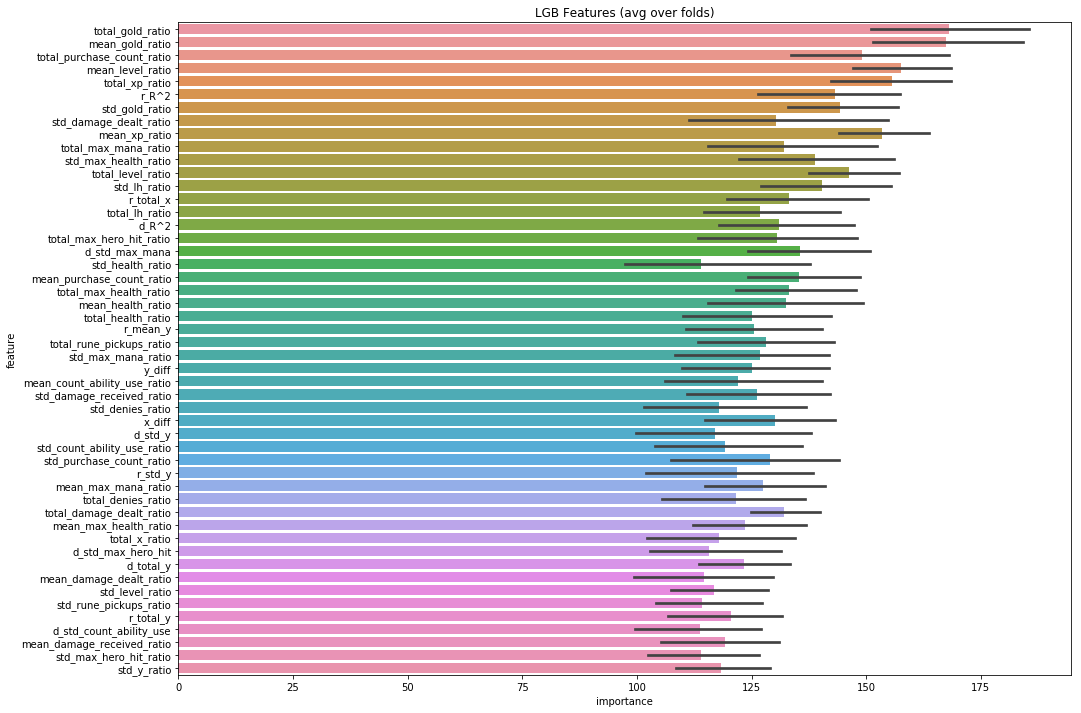

In [8]:
import time
oof_lgb, prediction_lgb, scores = train_model(X_train_7, X_test_7, y, params=params, 
                                              folds=folds, model_type='lgb', 
                                              plot_feature_importance=True)

In [9]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'test_features.csv'), 
                                    index_col='match_id_hash')

In [10]:
df_submission = pd.DataFrame(
    {'radiant_win_prob': prediction_lgb}, 
    index=df_test_features.index,)

df_submission.to_csv('sumbmission_lgb1_f7.csv')

In [11]:
X_train_7_cat = pd.read_pickle("./train_features_7_cat.pkl")
X_test_7_cat = pd.read_pickle("./test_features_7_cat.pkl")

Fold 0 started at Mon Nov 18 01:10:20 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.889399	valid_1's auc: 0.834812
[2000]	training's auc: 0.932879	valid_1's auc: 0.841148
[3000]	training's auc: 0.95976	valid_1's auc: 0.843214
Early stopping, best iteration is:
[3669]	training's auc: 0.972043	valid_1's auc: 0.84377
Fold 1 started at Mon Nov 18 01:11:19 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.890888	valid_1's auc: 0.82323
[2000]	training's auc: 0.933563	valid_1's auc: 0.829146
[3000]	training's auc: 0.960103	valid_1's auc: 0.831216
[4000]	training's auc: 0.977236	valid_1's auc: 0.832111
Early stopping, best iteration is:
[3932]	training's auc: 0.976292	valid_1's auc: 0.832144
Fold 2 started at Mon Nov 18 01:12:20 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.888586	valid_1's auc: 0.837327
[2000]	training's auc: 0.932323	valid_1's auc: 0.843072
[3

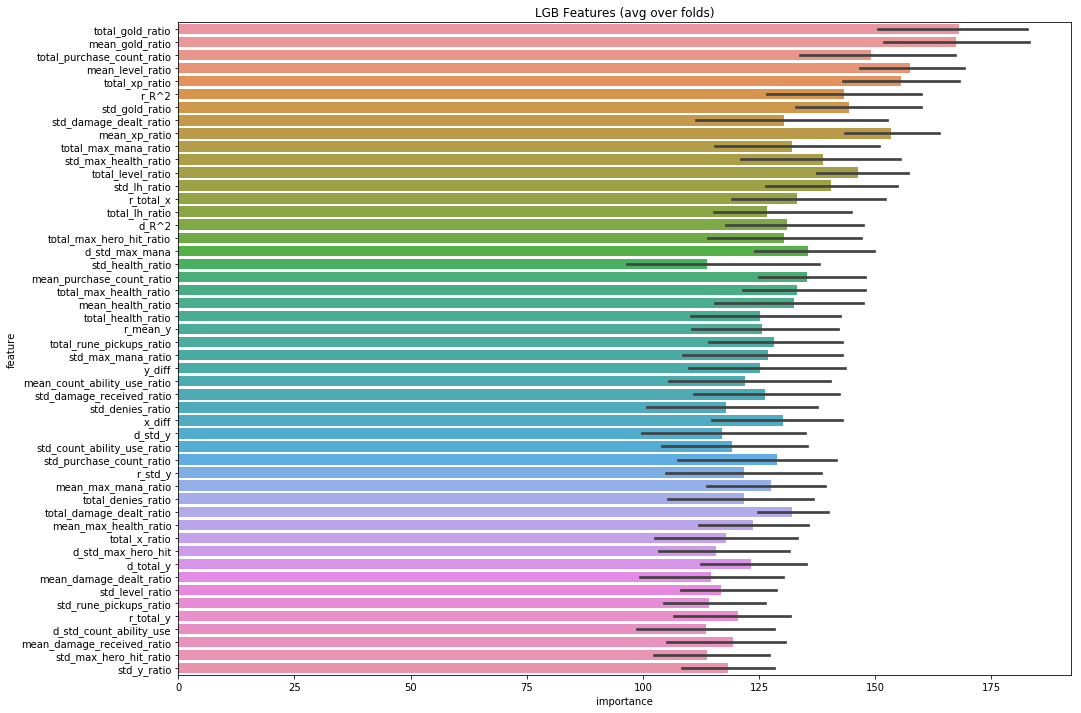

In [12]:
import time
oof_lgb_cat, prediction_lgb_cat, scores_cat = train_model(X_train_7_cat, X_test_7_cat, y, params=params, 
                                              folds=folds, model_type='lgb', 
                                              plot_feature_importance=True)